In [1]:
import numpy as np
from PIL import Image
import os
import keras 

TUMOR_path = 'Kather_texture_2016_image_tiles_5000/01_TUMOR/'
STROMA_path = 'Kather_texture_2016_image_tiles_5000/02_STROMA/'
COMPLEX_path = 'Kather_texture_2016_image_tiles_5000/03_COMPLEX/'
LYMPHO_path = 'Kather_texture_2016_image_tiles_5000/04_LYMPHO/'
DEBRIS_path = 'Kather_texture_2016_image_tiles_5000/05_DEBRIS/'
MUCOSA_path= 'Kather_texture_2016_image_tiles_5000/06_MUCOSA/'
ADIPOSE_path = 'Kather_texture_2016_image_tiles_5000/07_ADIPOSE/'
EMPTY_path = 'Kather_texture_2016_image_tiles_5000/08_EMPTY/'

#Load the images from each folder path
TUMOR = np.array([np.array(Image.open(TUMOR_path + fname)) for fname in os.listdir(TUMOR_path)])
STROMA = np.array([np.array(Image.open(STROMA_path + fname)) for fname in os.listdir(STROMA_path)])
COMPLEX = np.array([np.array(Image.open(COMPLEX_path + fname)) for fname in os.listdir(COMPLEX_path)])
LYMPHO = np.array([np.array(Image.open(LYMPHO_path + fname)) for fname in os.listdir(LYMPHO_path)])
DEBRIS = np.array([np.array(Image.open(DEBRIS_path + fname)) for fname in os.listdir(DEBRIS_path)])
MUCOSA = np.array([np.array(Image.open(MUCOSA_path + fname)) for fname in os.listdir(MUCOSA_path)])
ADIPOSE = np.array([np.array(Image.open(ADIPOSE_path + fname)) for fname in os.listdir(ADIPOSE_path)])
EMPTY = np.array([np.array(Image.open(EMPTY_path + fname)) for fname in os.listdir(EMPTY_path)])

#Create the labels for each image so we know which image belongs to which class
TUMOR_labels = np.ones((len(TUMOR),1))
STROMA_labels = np.ones((len(STROMA),1))*2
COMPLEX_labels = np.ones((len(COMPLEX),1))*3
LYMPHO_labels = np.ones((len(LYMPHO),1))*4
DEBRIS_labels = np.ones((len(DEBRIS),1))*5
MUCOSA_labels = np.ones((len(MUCOSA),1))*6
ADIPOSE_labels = np.ones((len(ADIPOSE),1))*7
EMPTY_labels = np.ones((len(EMPTY),1))*8

In [2]:
#Combine all the images and labels into one X and y array
X = np.concatenate((TUMOR,STROMA,COMPLEX,LYMPHO,DEBRIS,MUCOSA,ADIPOSE,EMPTY),axis=0)
y = np.concatenate((TUMOR_labels,STROMA_labels,COMPLEX_labels,LYMPHO_labels,DEBRIS_labels,MUCOSA_labels,ADIPOSE_labels,EMPTY_labels),axis=0)

#Shuffle the data (prevents non random assignment to training and testing)
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=0)

#Split the data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#resize the images to 50x50 pixels and 3 channels (RGB)
from keras_preprocessing.image import img_to_array, array_to_img
X_train = np.array([img_to_array(array_to_img(im, scale=False).resize((50,50))) for im in X_train])
X_test = np.array([img_to_array(array_to_img(im, scale=False).resize((50,50))) for im in X_test])

#Normalize the data to be between 0 and 1 for same scale
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255


In [4]:
X_train.shape

(4000, 50, 50, 3)

In [3]:
from keras.preprocessing.image import ImageDataGenerator
#Create the data generator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [6]:
X_train.shape

(4000, 50, 50, 3)

In [4]:
#One hot encode the labels
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [16]:
y_train.shape

(4000, 9)

In [5]:
#Create the model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout

#add early stopping function to stop NN epochs if no improvement in validation loss after 3 consecutive epochs
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

#initiates neural network model
model1 = Sequential()
#adds first layer, 
model1.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(50,50,3)))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(64, kernel_size=3, activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(128, kernel_size=3, activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(9, activation='softmax'))


#Compile the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [6]:
#Train the model
model1_history = model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200,callbacks=[callback])

Epoch 1/200
125/125 [==============================] - 21s 151ms/step - loss: 1.4754 - accuracy: 0.3695 - val_loss: 1.0703 - val_accuracy: 0.4910
Epoch 2/200
125/125 [==============================] - 20s 156ms/step - loss: 1.1213 - accuracy: 0.5077 - val_loss: 0.9641 - val_accuracy: 0.5390
Epoch 3/200
125/125 [==============================] - 16s 126ms/step - loss: 1.0244 - accuracy: 0.5600 - val_loss: 0.8225 - val_accuracy: 0.6830
Epoch 4/200
125/125 [==============================] - 16s 127ms/step - loss: 0.9158 - accuracy: 0.6260 - val_loss: 0.8003 - val_accuracy: 0.5980
Epoch 5/200
125/125 [==============================] - 16s 126ms/step - loss: 0.8447 - accuracy: 0.6618 - val_loss: 0.7222 - val_accuracy: 0.7310
Epoch 6/200
125/125 [==============================] - 16s 128ms/step - loss: 0.8760 - accuracy: 0.6528 - val_loss: 0.7659 - val_accuracy: 0.6830
Epoch 7/200
125/125 [==============================] - 14s 115ms/step - loss: 0.7703 - accuracy: 0.7053 - val_loss: 0.7052 -

So this model stops improving after 25 epochs
This model was chosen at random, can we change the structure of the neural network or optimise the parameters in any way?

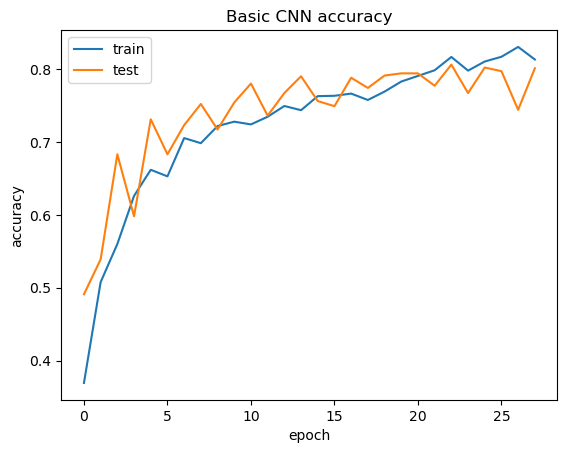

In [10]:
#plot the training and validation accuracy and loss over each epoch
import matplotlib.pyplot as plt
#plot the training and validation accuracy for each epoch, overlaying the training and validation accuracy for each epoch with 2 different colors
plt.plot(model1_history.history['accuracy'])
plt.plot(model1_history.history['val_accuracy'])
plt.title('Basic CNN accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

32/32 [==============================] - 1s 17ms/step


Text(95.72222222222221, 0.5, 'Truth')

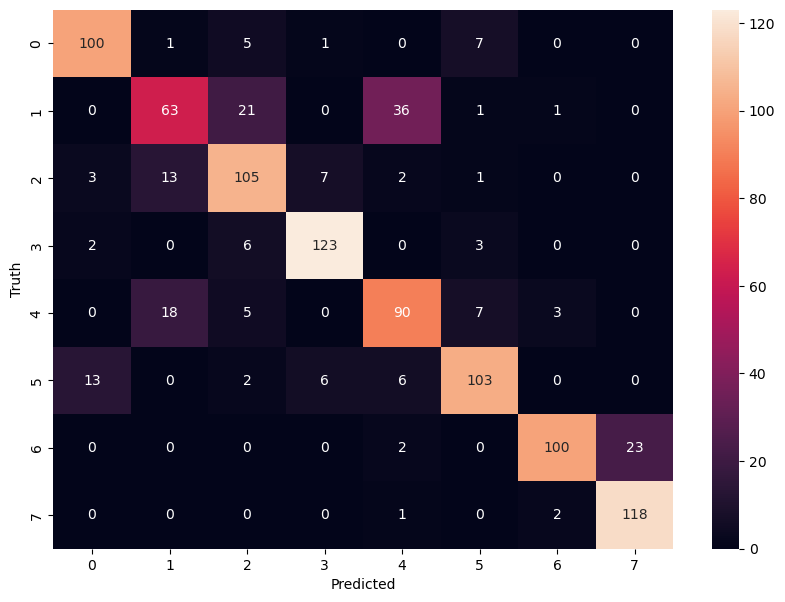

In [24]:
#use model on test data
y_pred = model1.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

#create a confusion matrix to see how well the model performed on the test data
import matplotlib.pyplot as plt
#Create the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

#plot confusion matrix cm
import seaborn as sns
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')


In [16]:

#initiates neural network model
model2 = Sequential()
#adds first layer, 
model2.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(50,50,3)))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(64, kernel_size=3, activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(128, kernel_size=3, activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(9, activation='softmax'))


#Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
#initiates neural network model
model3 = Sequential()
#adds first layer, 
model3.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(50,50,3)))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Conv2D(64, kernel_size=3, activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Conv2D(128, kernel_size=3, activation='relu'))
model3.add(Conv2D(256, kernel_size=3, activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Flatten())
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(9, activation='softmax'))


#Compile the model
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
model3_history = model3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200,callbacks=[callback])

Epoch 1/200
125/125 [==============================] - 19s 149ms/step - loss: 0.7150 - accuracy: 0.7290 - val_loss: 0.8404 - val_accuracy: 0.6090
Epoch 2/200
125/125 [==============================] - 18s 142ms/step - loss: 0.6864 - accuracy: 0.7385 - val_loss: 0.6076 - val_accuracy: 0.7720
Epoch 3/200
125/125 [==============================] - 21s 172ms/step - loss: 0.5772 - accuracy: 0.7893 - val_loss: 0.5470 - val_accuracy: 0.7920
Epoch 4/200
125/125 [==============================] - 19s 154ms/step - loss: 0.5519 - accuracy: 0.7970 - val_loss: 0.5610 - val_accuracy: 0.7830
Epoch 5/200
125/125 [==============================] - 23s 186ms/step - loss: 0.5669 - accuracy: 0.7883 - val_loss: 0.6168 - val_accuracy: 0.7740
Epoch 6/200
125/125 [==============================] - 23s 185ms/step - loss: 0.5574 - accuracy: 0.7885 - val_loss: 0.6008 - val_accuracy: 0.7720
Epoch 6: early stopping


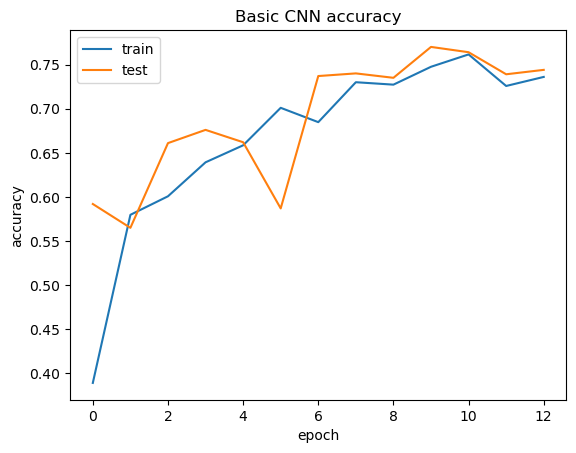

In [22]:
#plot the training and validation accuracy for each epoch, overlaying the training and validation accuracy for each epoch with 2 different colors
plt.plot(model3_history.history['accuracy'])
plt.plot(model3_history.history['val_accuracy'])
plt.title('Basic CNN accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()